In [1]:
import os
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm  # ilerleme çubuğu için
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

base_path = '/kaggle/input/wikiart-art-movementsstyles'

KeyboardInterrupt: 

In [78]:
# rgb-colors dosyasını yapıyor
#  Ana klasör
base_path = '/kaggle/input/wikiart-art-movementsstyles'

# Sanat akımlarına göre sayım
style_counts = defaultdict(int)

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            style = os.path.basename(root)
            style_counts[style] += 1

# Sonuçları yazdır
for style, count in sorted(style_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{style}: {count} görsel")


KeyboardInterrupt: 

In [79]:
def get_dominant_colors(image_path, n_colors=3, resize_dim=(150, 150)):
    """Görselden n baskın rengi döndürür (KMeans ile)."""
    img = Image.open(image_path).convert('RGB').resize(resize_dim)
    img_np = np.array(img).reshape(-1, 3)

    # KMeans ile kümeleme
    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=42)
    kmeans.fit(img_np)
    return kmeans.cluster_centers_.astype(int)  # RGB renkler

# Veri kümesinin kök dizini
root_dir = '/kaggle/input/wikiart-art-movementsstyles'
styles = [s for s in os.listdir(root_dir) if not s.startswith('.')]  # gizli dosyaları atla

data = []
max_images_per_style = 100  # her stil için maksimum görsel

# Stil klasörlerini dolaş
for style in tqdm(styles, desc="Sanat akımları işleniyor"):
    style_dir = os.path.join(root_dir, style, style)
    if not os.path.isdir(style_dir):
        continue
    
    image_files = [f for f in os.listdir(style_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    image_files = image_files[:max_images_per_style]

    for img_file in image_files:
        img_path = os.path.join(style_dir, img_file)
        try:
            colors = get_dominant_colors(img_path, n_colors=3)
            for i, c in enumerate(colors, 1):
                data.append({
                    'Style': style,
                    'Color_Index': i,
                    'R': c[0], 'G': c[1], 'B': c[2],
                    'Image': img_file
                })
        except Exception as e:
            print(f"Hata ({img_file}): {e}")
            continue

# DataFrame ve CSV kaydı
df_palettes = pd.DataFrame(data)
output_path = '/kaggle/working/wikiart_rgb_3colors_per_image.csv'
df_palettes.to_csv(output_path, index=False)

print("✅ İşlem tamamlandı. Dosya:", output_path)

Sanat akımları işleniyor:   0%|          | 0/13 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [81]:

df_palettes = pd.read_csv('/kaggle/working/wikiart_rgb_3colors_per_image.csv')

def rgb_to_hsl(row):
    r, g, b = row['R'] / 255, row['G'] / 255, row['B'] / 255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return pd.Series({'Hue': h * 360, 'Lightness': l * 100, 'Saturation': s * 100})

hsl_df = df_palettes.apply(rgb_to_hsl, axis=1)
df_palettes = pd.concat([df_palettes, hsl_df], axis=1)

df_palettes.to_csv('/kaggle/working/wikiart_with_hsl.csv', index=False)
print("✔️ HSL bilgileri eklendi.")


✔️ HSL bilgileri eklendi.


In [82]:

features = df_palettes[['Hue', 'Lightness', 'Saturation']]
kmeans = KMeans(n_clusters=5, random_state=42)
df_palettes['Cluster'] = kmeans.fit_predict(features)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:

# KMeans modelini tanımla
X = df_palettes[['Hue', 'Saturation', 'Lightness']]
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

# fit_predict sonucunu düz 1D array'e çevirerek ata
clusters = kmeans.fit_predict(X)
df_palettes['Cluster'] = np.squeeze(clusters)  # squeeze ile 2D ise 1D'ye düşür

# Emin olmak için dtype kontrolü
df_palettes['Cluster'] = df_palettes['Cluster'].astype(int)


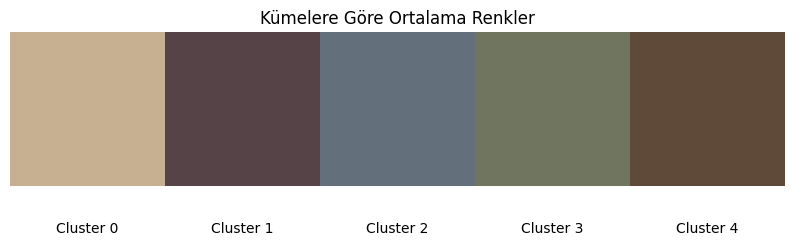

In [84]:

# Küme bazında ortalama RGB hesapla
avg_colors = df_palettes.groupby('Cluster')[['R', 'G', 'B']].mean().astype(int)

# Paleti çiz
fig, ax = plt.subplots(1, figsize=(10, 2))
for idx, (i, row) in enumerate(avg_colors.iterrows()):
    color = tuple(row / 255)  # RGB'yi [0,1] aralığına getir
    rect = patches.Rectangle((idx, 0), 1, 1, facecolor=color)
    ax.add_patch(rect)
    ax.text(idx + 0.5, -0.3, f'Cluster {i}', ha='center', fontsize=10)

plt.xlim(0, len(avg_colors))
plt.ylim(0, 1)
plt.axis('off')
plt.title('Kümelere Göre Ortalama Renkler')
plt.show()

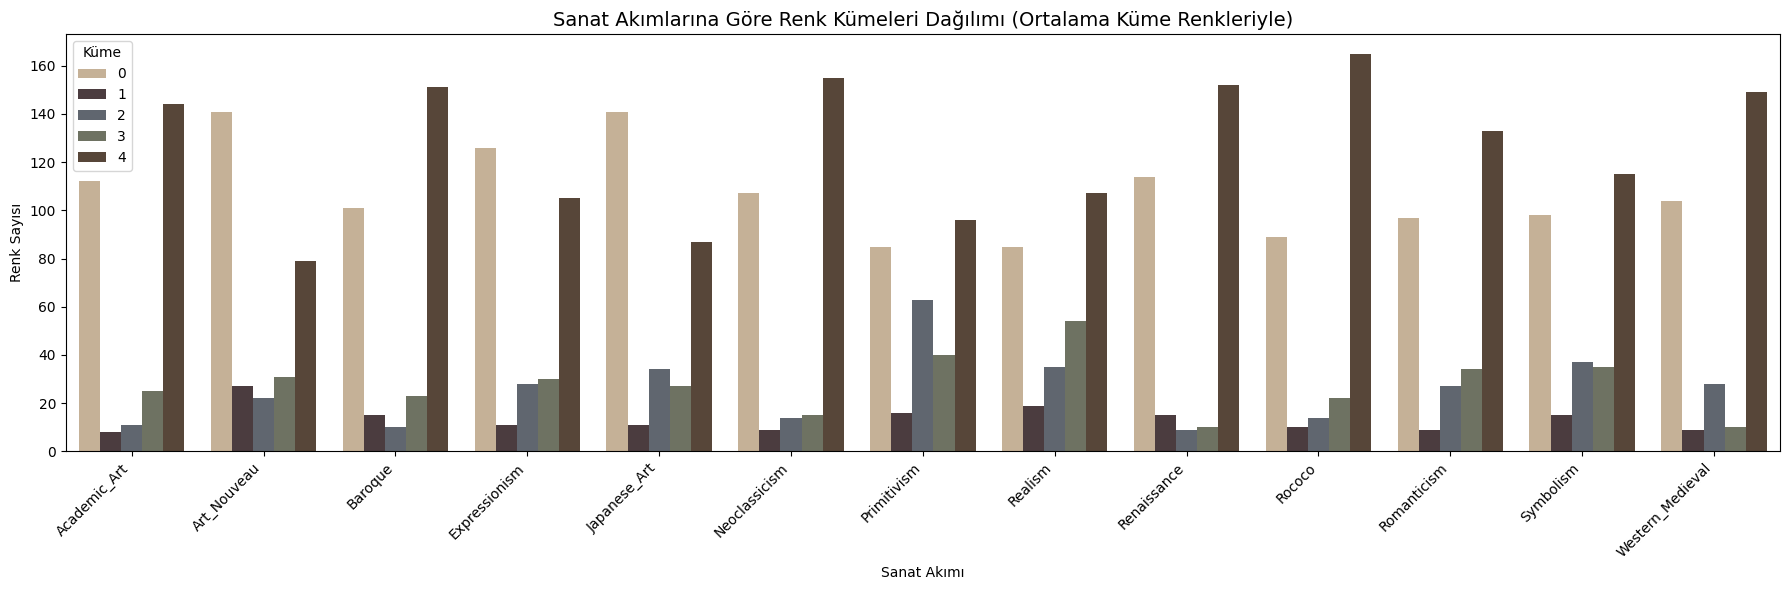

In [85]:
# Küme ortalama renkleri (Cluster 0–4)
cluster_colors = {
    0: '#ccb290',  # açık bej
    1: '#4e393d',  # koyu bordo
    2: '#5e6671',  # mavi-gri
    3: '#70755f',  # zeytin yeşili
    4: '#5c4534',  # kahverengi
}

# Küme dağılımı: Stil ve Küme bazında renk sayıları
grouped = df_palettes.groupby(['Style', 'Cluster']).size().reset_index(name='Count')

# Stil sıralamasını sabitle (görsel düzgün çıksın)
style_order = sorted(df_palettes['Style'].unique())

# Çizim
plt.figure(figsize=(18, 6))
sns.barplot(
    data=grouped,
    x='Style',
    y='Count',
    hue='Cluster',
    palette=[cluster_colors[c] for c in sorted(cluster_colors)],
    order=style_order,
    hue_order=sorted(cluster_colors)
)

plt.title('Sanat Akımlarına Göre Renk Kümeleri Dağılımı (Ortalama Küme Renkleriyle)', fontsize=14)
plt.xlabel('Sanat Akımı')
plt.ylabel('Renk Sayısı')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Küme')
plt.tight_layout()
plt.show()


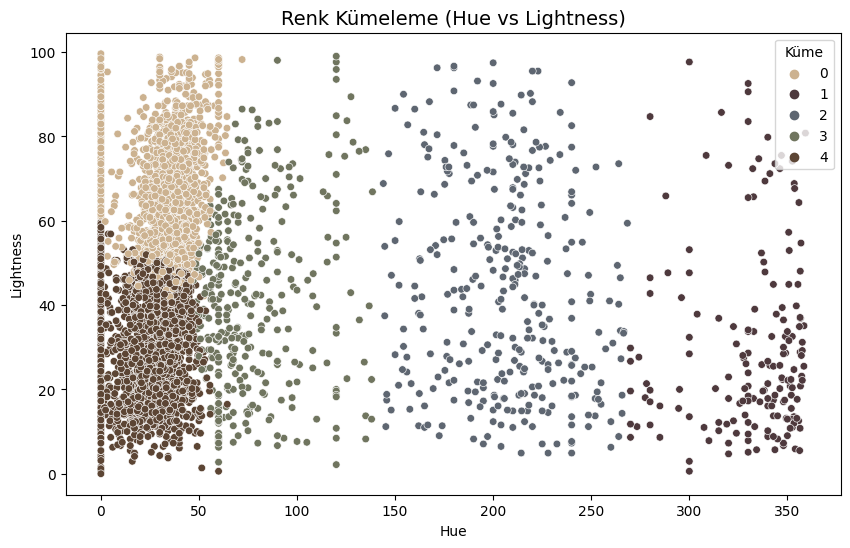

In [86]:
# Küme renkleri (ortalama renk paleti)
cluster_colors = {
    0: '#ccb290',  # bej
    1: '#4e393d',  # bordo
    2: '#5e6671',  # gri-mavi
    3: '#70755f',  # zeytin
    4: '#5c4534',  # kahve
}

# Paleti sırayla listele (seaborn uyumlu format)
palette = [cluster_colors[i] for i in sorted(cluster_colors)]

# Grafik çizimi
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_palettes,
    x='Hue',
    y='Lightness',
    hue='Cluster',
    palette=palette,
    s=30
)
plt.title('Renk Kümeleme (Hue vs Lightness)', fontsize=14)
plt.legend(title='Küme')
plt.show()

In [87]:
# RGB'yi normalize et (0-1 arası)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_palettes[['R', 'G', 'B']])

# K-Means kümeleme (örneğin 5 küme)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_palettes['Cluster_RGB'] = kmeans.fit_predict(X_scaled)

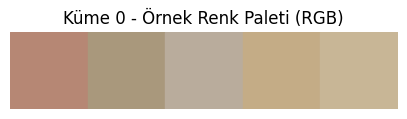

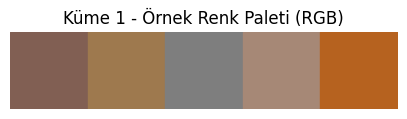

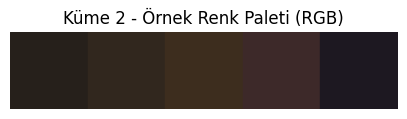

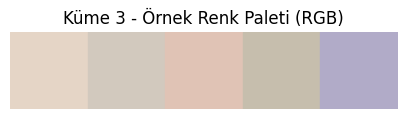

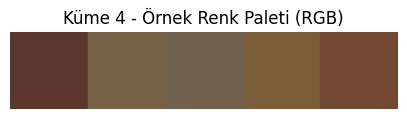

In [89]:
def plot_color_palette(colors, title):
    n = len(colors)
    fig, ax = plt.subplots(figsize=(n, 1))
    for i, color in enumerate(colors):
        rgb = np.array(color) / 255  # RGB değerlerini 0-1 aralığına çevir
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=rgb))
    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# Her Cluster_RGB kümesi için ilk 5 örnek renk paletini çiz
for cluster_id in sorted(df_palettes['Cluster_RGB'].unique()):
    cluster_colors = df_palettes[df_palettes['Cluster_RGB'] == cluster_id][['R', 'G', 'B']].head(5).values.tolist()
    plot_color_palette(cluster_colors, title=f"Küme {cluster_id} - Örnek Renk Paleti (RGB)")

In [90]:

# 1. Sanat akımlarına göre ortalama RGB hesapla
average_rgb = df_palettes.groupby('Style')[['R', 'G', 'B']].mean().reset_index()

# 2. RGB → HSL dönüşüm fonksiyonu
def rgb_to_hsl(rgb_tuple):
    r, g, b = [x / 255 for x in rgb_tuple]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return h * 360, s * 100, l * 100

# 3. Her satır için HSL hesapla
average_rgb[['Hue', 'Saturation', 'Lightness']] = average_rgb.apply(
    lambda row: pd.Series(rgb_to_hsl((row['R'], row['G'], row['B']))),
    axis=1
)

# 4. HSL verilerini ölçekle (KMeans için standartlaştırma önemli)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(average_rgb[['Hue', 'Saturation', 'Lightness']])

# 5. KMeans kümeleme (5 küme olacak şekilde)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
average_rgb['Cluster'] = kmeans.fit_predict(X_scaled)

# 6. Sonuçları göster
print(average_rgb[['Style', 'Cluster']].sort_values('Cluster'))


               Style  Cluster
5      Neoclassicism        0
6        Primitivism        0
10       Romanticism        0
11         Symbolism        0
7            Realism        1
2            Baroque        2
9             Rococo        2
1        Art_Nouveau        3
3      Expressionism        3
4       Japanese_Art        3
0       Academic_Art        4
8        Renaissance        4
12  Western_Medieval        4


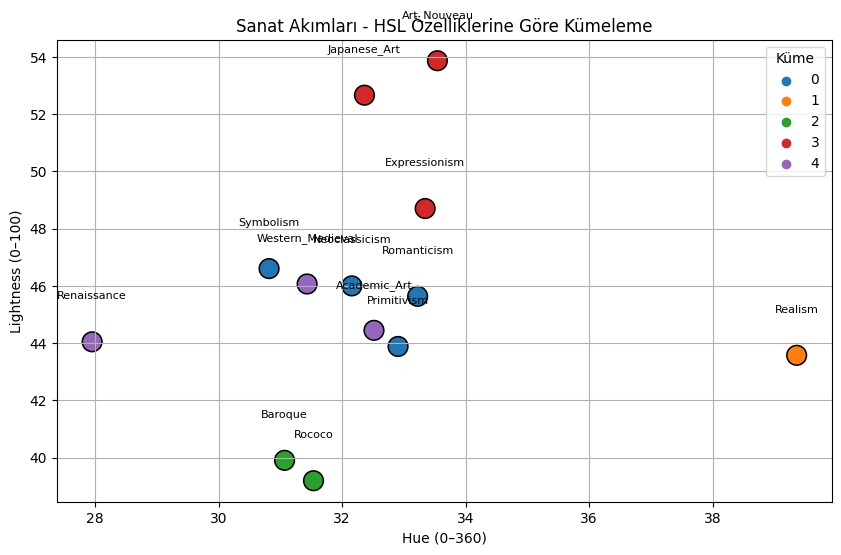

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=average_rgb,
    x='Hue',
    y='Lightness',
    hue='Cluster',
    palette='tab10',
    s=200,
    edgecolor='k'
)

for i, row in average_rgb.iterrows():
    plt.text(row['Hue'], row['Lightness'] + 1.5, row['Style'], fontsize=8, ha='center')

plt.xlabel('Hue (0–360)')
plt.ylabel('Lightness (0–100)')
plt.title('Sanat Akımları - HSL Özelliklerine Göre Kümeleme')
plt.grid(True)
plt.legend(title='Küme')
plt.show()

In [92]:
# 1. Duygu eşleme kuralları (aralık: (alt, üst), etiket)
emotion_rules = {
    'Hue': [
        ((0, 10), 'Öfke / Saldırganlık'),
        ((10, 30), 'Tutku / Enerji'),
        ((30, 50), 'Canlılık / Neşe'),
        ((50, 70), 'Mutluluk / Sıcaklık'),
        ((70, 90), 'Tazelik / Doğallık'),
        ((90, 110), 'Huzur / Dinginlik'),
        ((110, 130), 'Sakinlik / Doğa'),
        ((130, 160), 'Sonsuzluk / Mesafe'),
        ((160, 200), 'Güven / Ciddiyet'),
        ((200, 240), 'Yalnızlık / Soğukluk'),
        ((240, 280), 'Hayal / Romantizm'),
        ((280, 320), 'Yaratıcılık / Gizem'),
        ((320, 350), 'Dengesizlik / Yoğunluk'),
        ((350, 360), 'Öfke / Saldırganlık'),
    ],
    'Saturation': [
        ((0, 20), 'Sakinlik / Huzur'),
        ((20, 40), 'Melankoli / Düşünce'),
        ((40, 60), 'Neşe / Sıcakkanlılık'),
        ((60, 80), 'Coşku / Canlılık'),
        ((80, 100), 'Tutku / Enerji'),
    ],
    'Lightness': [
        ((0, 20), 'Bilinmeyen'),
        ((20, 40), 'Melankoli / Düşünce'),
        ((40, 60), 'Sakinlik / Huzur'),
        ((60, 80), 'Neşe / Sıcakkanlılık'),
        ((80, 100), 'Doğa / Tazelik'),
    ]
}



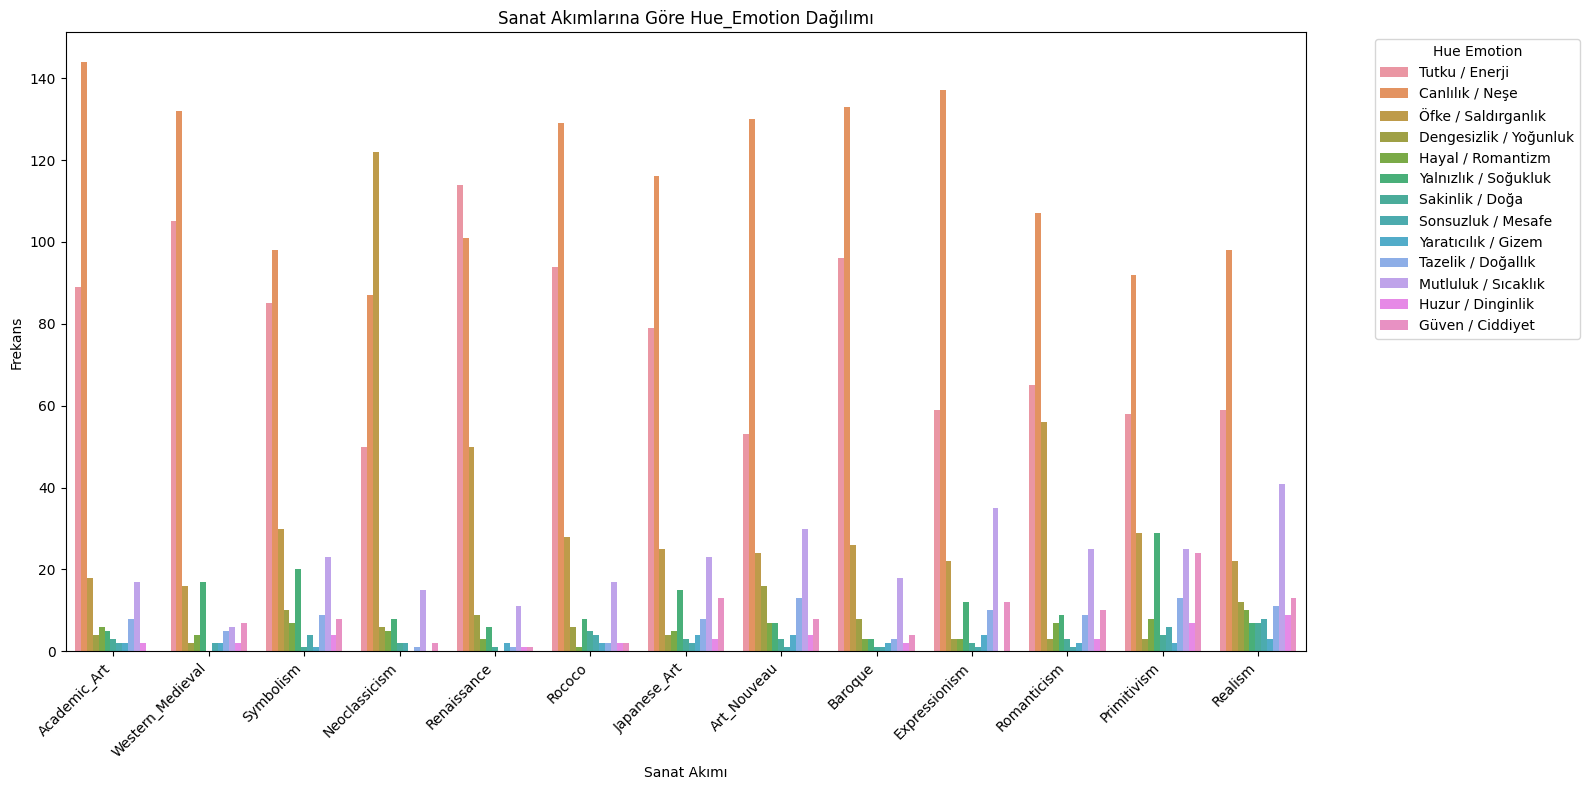

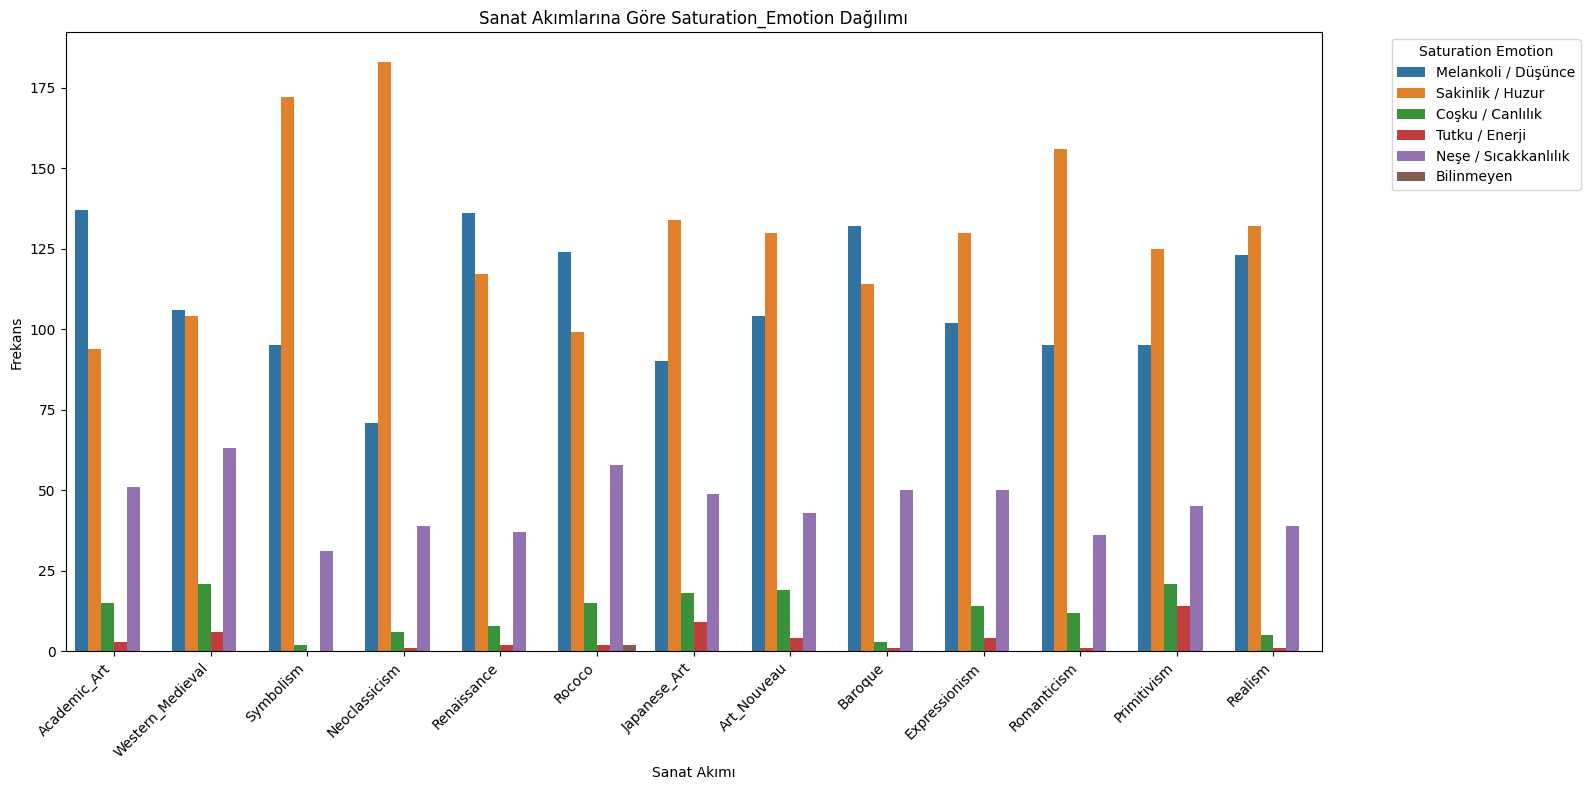

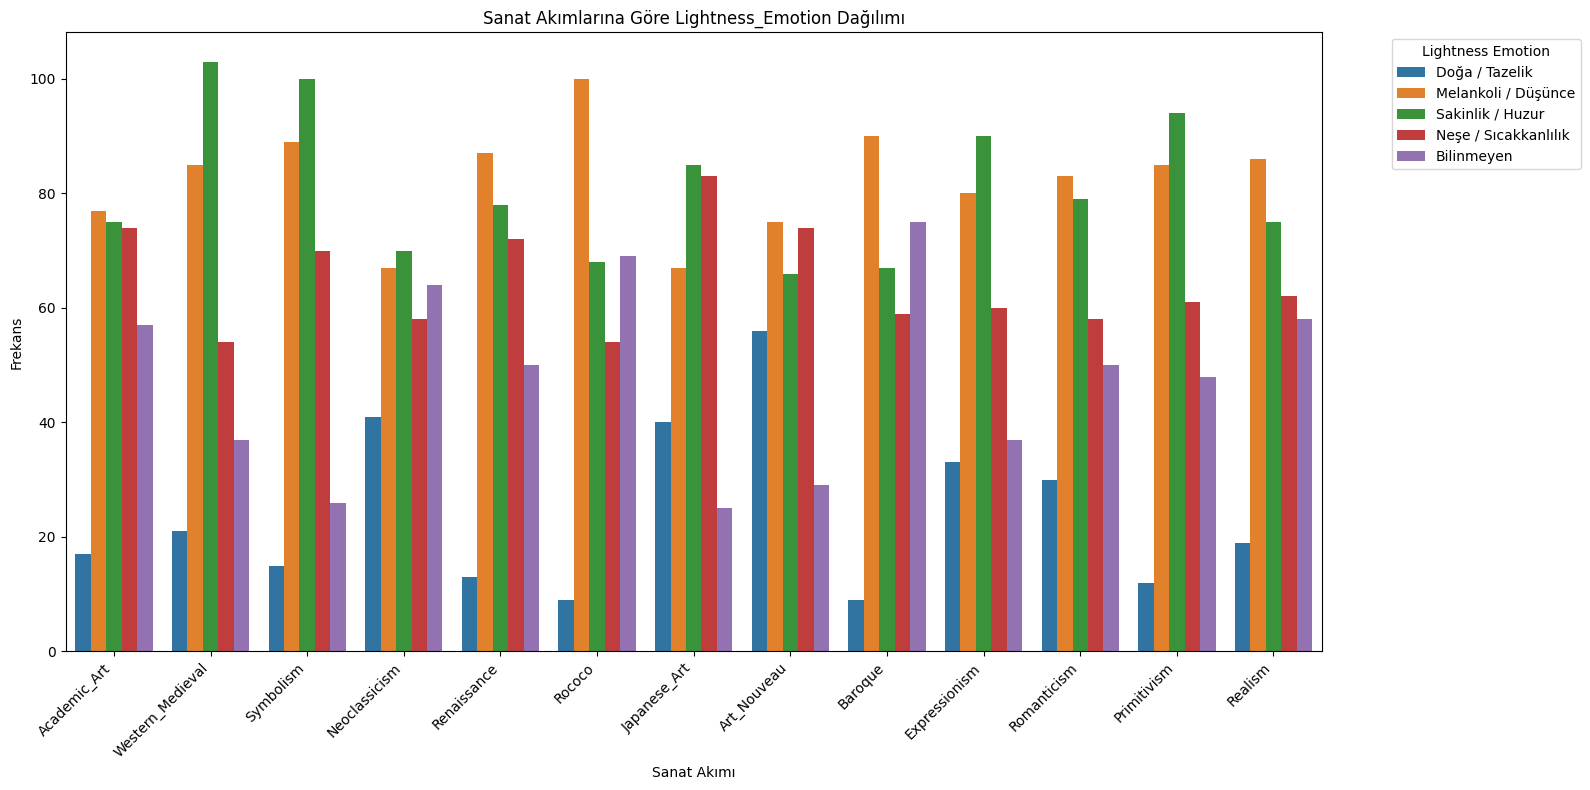

In [93]:
def assign_emotion(value, rules):
    for (low, high), label in rules:
        if low <= value < high:
            return label
    return 'Bilinmeyen'

for col in ['Hue', 'Saturation', 'Lightness']:
    label_col = f'{col}_Emotion'
    df_palettes[label_col] = df_palettes[col].apply(lambda v: assign_emotion(v, emotion_rules[col]))


def plot_emotion_distribution(df, emotion_col, title=''):
    plt.figure(figsize=(16, 8))
    sns.countplot(data=df, x='Style', hue=emotion_col)
    plt.xticks(rotation=45, ha='right')
    plt.title(title or f'Sanat Akımlarına Göre {emotion_col} Dağılımı')
    plt.xlabel('Sanat Akımı')
    plt.ylabel('Frekans')
    plt.legend(title=emotion_col.replace('_', ' '), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for col in ['Hue', 'Saturation', 'Lightness']:
    plot_emotion_distribution(df_palettes, f'{col}_Emotion')


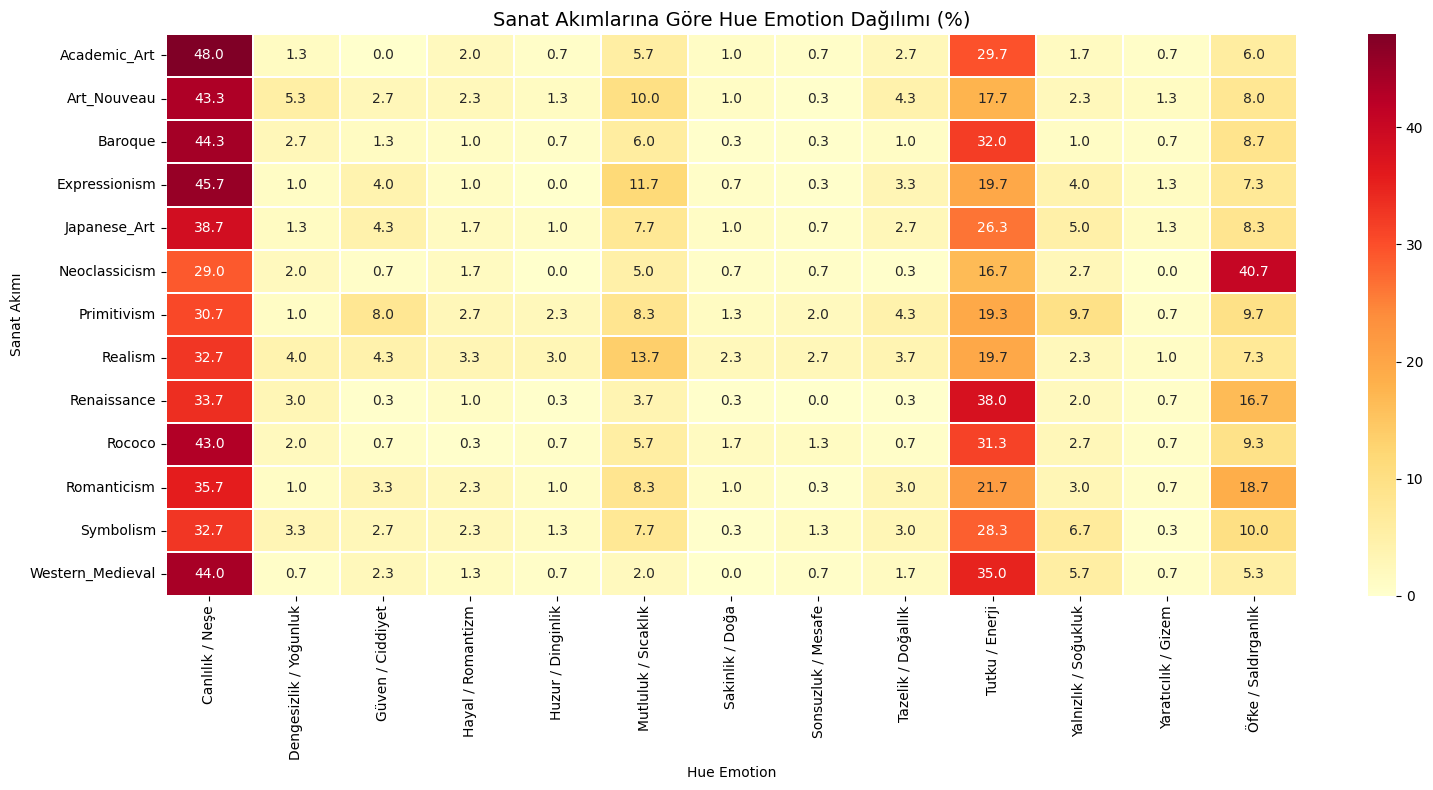

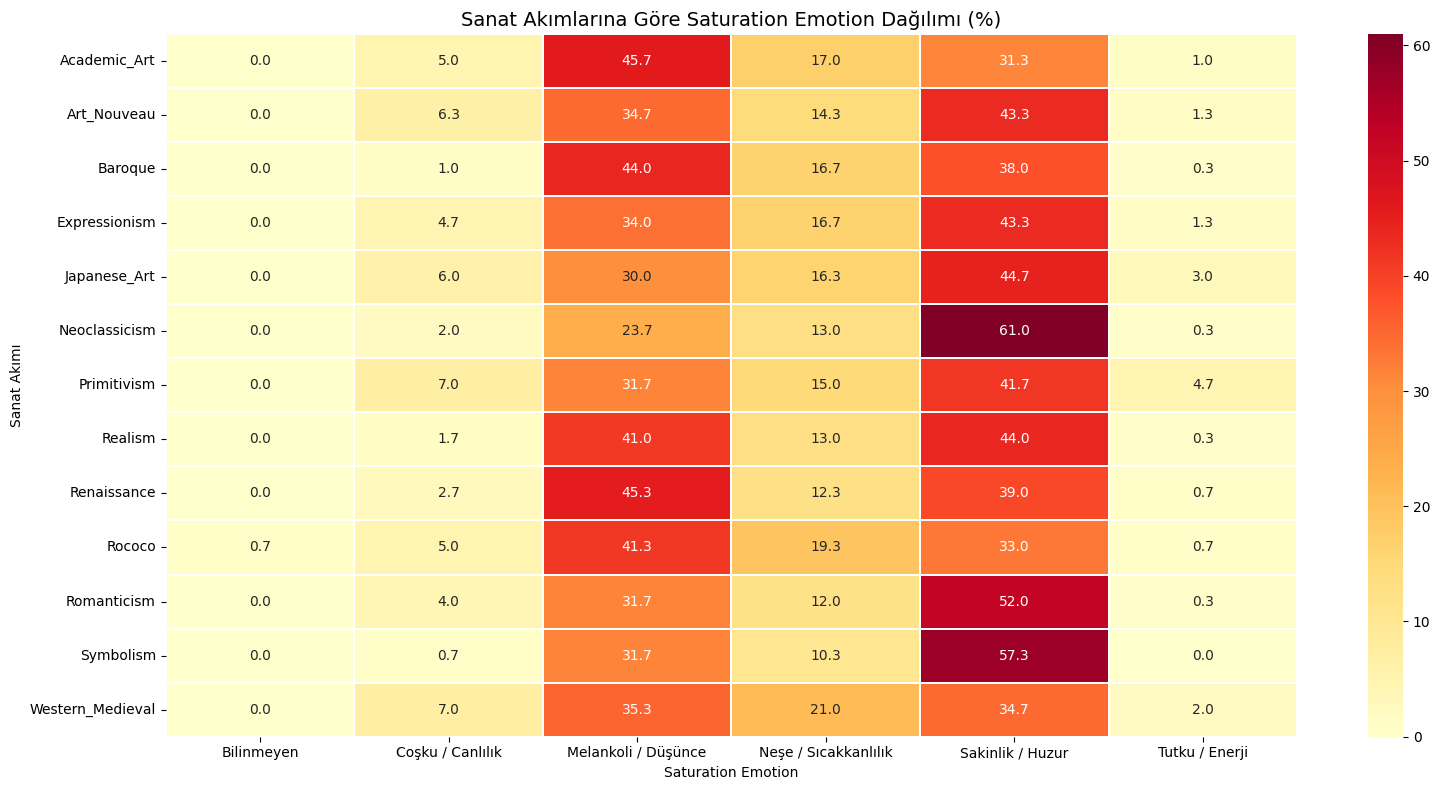

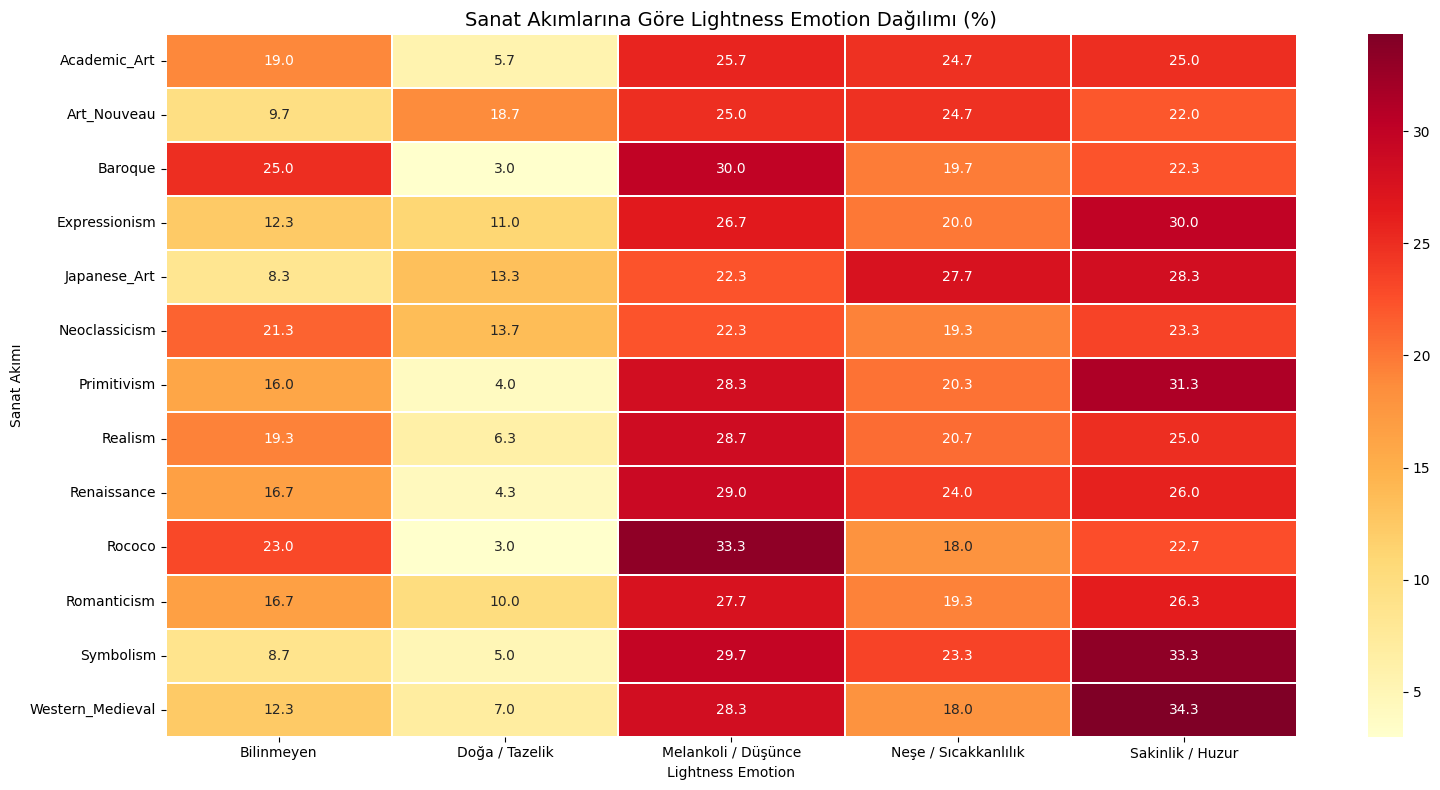

In [94]:
# Hue_Emotion için oran tablosu
hue_pivot = df_palettes.pivot_table(
    index='Style',
    columns='Hue_Emotion',
    values='Image',  # ya da 'R' → herhangi bir sayısal değer
    aggfunc='count',
    fill_value=0
)

# Yüzdeye çevir
hue_pivot_percent = hue_pivot.div(hue_pivot.sum(axis=1), axis=0) * 100


for col in ['Hue_Emotion', 'Saturation_Emotion', 'Lightness_Emotion']:
    pivot = df_palettes.pivot_table(index='Style', columns=col, values='Image', aggfunc='count', fill_value=0)
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(16, 8))
    sns.heatmap(pivot_pct, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.3)
    plt.title(f"Sanat Akımlarına Göre {col.replace('_', ' ')} Dağılımı (%)", fontsize=14)
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel("Sanat Akımı")
    plt.tight_layout()
    plt.show()


In [95]:

def chi2_test_emotion(df, emotion_col):
    # Sanat akımı ve duygu sütunu arasında çapraz tablo
    contingency = pd.crosstab(df['Style'], df[emotion_col])

    # Ki-kare testi uygulanır
    chi2, p, dof, expected = chi2_contingency(contingency)

    # Sonuç yazdır
    print(f"\n--- {emotion_col} için Ki-kare testi sonuçları ---")
    print(f"Ki-kare istatistiği : {chi2:.2f}")
    print(f"Serbestlik derecesi : {dof}")
    print(f"P-değeri            : {p:.5f}")

    if p < 0.05:
        print("✅ Sonuç: Sanat akımı ile bu duygu dağılımı arasında anlamlı bir fark VAR.")
    else:
        print("⚠️  Sonuç: Anlamlı bir fark GÖZLEMLENMEDİ (bağımsız olabilir).")

# Uygulama: Hue, Saturation, Lightness için döngü
for col in ['Hue_Emotion', 'Saturation_Emotion', 'Lightness_Emotion']:
    chi2_test_emotion(df_palettes, col)



--- Hue_Emotion için Ki-kare testi sonuçları ---
Ki-kare istatistiği : 701.04
Serbestlik derecesi : 144
P-değeri            : 0.00000
✅ Sonuç: Sanat akımı ile bu duygu dağılımı arasında anlamlı bir fark VAR.

--- Saturation_Emotion için Ki-kare testi sonuçları ---
Ki-kare istatistiği : 254.37
Serbestlik derecesi : 60
P-değeri            : 0.00000
✅ Sonuç: Sanat akımı ile bu duygu dağılımı arasında anlamlı bir fark VAR.

--- Lightness_Emotion için Ki-kare testi sonuçları ---
Ki-kare istatistiği : 224.29
Serbestlik derecesi : 48
P-değeri            : 0.00000
✅ Sonuç: Sanat akımı ile bu duygu dağılımı arasında anlamlı bir fark VAR.


In [100]:
def describe_styles_emotions(df, emotion_cols, top_n=2, threshold=0.05):
    """
    Her sanat akımı için Hue, Saturation ve Lightness bazlı duygusal eğilimleri doğal cümlelerle açıklar.

    Parameters:
    - df: Ana DataFrame (df_palettes)
    - emotion_cols: Duygu sütunları (örneğin ['Hue_Emotion', 'Saturation_Emotion', 'Lightness_Emotion'])
    - top_n: Her özellik için en baskın kaç duygu dahil edilsin
    - threshold: Minimum yüzde oranı (örneğin %5 altı varsa ihmal edilir)

    Returns:
    - Cümle cinsinden açıklamalar listesi
    """
    styles = df['Style'].unique()
    descriptions = []

    for style in styles:
        style_subset = df[df['Style'] == style]
        desc_parts = []

        for col in emotion_cols:
            counts = style_subset[col].value_counts(normalize=True)
            top = counts[counts > threshold].nlargest(top_n)
            if top.empty:
                continue

            emotions = list(top.index)
            if len(emotions) == 1:
                joined = f"{emotions[0]}"
            else:
                joined = ", ".join(emotions[:-1]) + " ve " + emotions[-1]

            if 'Hue' in col:
                desc_parts.append(f"'{joined}' tonlarıyla")
            elif 'Saturation' in col:
                desc_parts.append(f"'{joined}' doygunluklarıyla")
            elif 'Lightness' in col:
                desc_parts.append(f"'{joined}' açıklıklarıyla")

        if desc_parts:
            full_desc = f"- {style} akımı genellikle " + " ve ".join(desc_parts) + " öne çıkar."
            descriptions.append(full_desc)

    return descriptions

emotion_columns = ['Hue_Emotion', 'Saturation_Emotion', 'Lightness_Emotion']
summary_texts = describe_styles_emotions(df_palettes, emotion_columns)

for text in summary_texts:
    print(text)

- Academic_Art akımı genellikle 'Canlılık / Neşe ve Tutku / Enerji' tonlarıyla ve 'Melankoli / Düşünce ve Sakinlik / Huzur' doygunluklarıyla ve 'Melankoli / Düşünce ve Sakinlik / Huzur' açıklıklarıyla öne çıkar.
- Western_Medieval akımı genellikle 'Canlılık / Neşe ve Tutku / Enerji' tonlarıyla ve 'Melankoli / Düşünce ve Sakinlik / Huzur' doygunluklarıyla ve 'Sakinlik / Huzur ve Melankoli / Düşünce' açıklıklarıyla öne çıkar.
- Symbolism akımı genellikle 'Canlılık / Neşe ve Tutku / Enerji' tonlarıyla ve 'Sakinlik / Huzur ve Melankoli / Düşünce' doygunluklarıyla ve 'Sakinlik / Huzur ve Melankoli / Düşünce' açıklıklarıyla öne çıkar.
- Neoclassicism akımı genellikle 'Öfke / Saldırganlık ve Canlılık / Neşe' tonlarıyla ve 'Sakinlik / Huzur ve Melankoli / Düşünce' doygunluklarıyla ve 'Sakinlik / Huzur ve Melankoli / Düşünce' açıklıklarıyla öne çıkar.
- Renaissance akımı genellikle 'Tutku / Enerji ve Canlılık / Neşe' tonlarıyla ve 'Melankoli / Düşünce ve Sakinlik / Huzur' doygunluklarıyla ve 'M